In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sys
import caffe
import os
# display plots in this notebook
%matplotlib inline
# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

In [5]:
def load_list(data_dir, prefix = None, dataset = 1):
    train_list = os.path.join(data_dir, 'train') + str(dataset) + '.idx'
    test_list = os.path.join(data_dir, 'test') + str(dataset) + '.idx'
    with open(train_list) as f:
        train_list = f.read().splitlines()
    with open(test_list) as f:
        test_list = f.read().splitlines()
    if prefix is not None:
        train_list = map(lambda x: os.path.join(prefix, x), train_list)
        test_list = map(lambda x: os.path.join(prefix, x), test_list)
    return train_list, test_list

def load_img(filename, flip = False, grayscale = False):
    if grayscale:
        img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    else:
        img = cv2.imread(filename)
    if flip:
        img = cv2.flip(img, 1)
    if grayscale:
        width, height = img.shape
    else:
        width, height, _ = img.shape
    factor = max(256.0 / width, 256.0 / height)
    img = cv2.resize(img, None, fx = factor, fy = factor)
    return img

def load_imgs(filenames, reverse = False, flip = False, grayscale = False):
    if reverse:
        filenames = filenames[::-1]
    imgs = map(lambda x: load_img(x, flip, grayscale), filenames)
    return imgs

def load_video(video, data_dir, mask = None, reverse = False, flip = False, grayscale = False):
    filenames = os.listdir(os.path.join(data_dir, video))
    filenames = filter(lambda x: x[-4:] == 'jpeg', filenames)
    if mask is not None:
        filenames = filter(mask, filenames)
    filenames.sort()
    filenames = map(lambda x: os.path.join(data_dir, video, x), filenames)
    imgs = load_imgs(filenames, reverse, flip, grayscale)
    return imgs

def is_forward(video):
    if video[0] == 'F':
        return True
    return False

def select(imgs, n = 5):
    mags = [None] * (len(imgs)/2)
    for i in range(len(imgs)/2):
        mag, _ = cv2.cartToPolar(np.asarray(imgs[2*i], dtype = np.float32), np.asarray(imgs[2*i+1], dtype = np.float32))
    mags[i] = cv2.norm(mag)
    mags = np.asarray(mags)
    idx = np.argsort(mags)[::-1][:n]
    idx.sort()
    return idx
def load_flows(video, direction):
    imgs_ = load_video(video, './data/ArrowDataAll', 
                               mask = lambda x: x[:3] == 'of' + direction, 
                               grayscale=True)
    imgs_ = map(lambda x: cv2.resize(x, (227, 227)), imgs_)
    return imgs_

In [6]:
caffe.set_mode_cpu()

In [7]:
model_def = 'models/alexnetplus/deploy_alexnetplusCAM_imagenet.prototxt'
model_weights = 'models/alexnetplus/alexnetplusCAM_imagenet.caffemodel'
net = caffe.Net(model_def, model_weights, caffe.TEST)

In [8]:
caffe_root = '/home/bysong/caffe/'
# load the mean ImageNet image (as distributed with Caffe) for subtraction
mu = np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy')
mu = mu.mean(1).mean(1)  # average over pixels to obtain the mean (BGR) pixel values

In [9]:
# create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': (1, 3, 227, 227)})
transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel

In [28]:
net.blobs['data'].reshape(1, 9, 227, 227)

In [29]:
train_list, test_list = load_list('./data', dataset = 1)

In [30]:
train = 'F_aqvxyejK0MQ'
imgs = load_video(train, './data/ArrowDataAll/')
direction = 'f'
flows = load_flows(train, direction)
idx = select(flows, 11)
imgs_ = np.take(imgs, idx, axis = 0)
imgs_ = np.asarray(map(lambda x: transformer.preprocess('data', x), imgs_))

In [31]:
imgs = []
for i in range(len(imgs_) - 2):
    imgs.append(np.concatenate(imgs_[i:i+3], axis = 0))
imgs = np.asarray(imgs)

In [32]:
img = imgs[0]

In [33]:
net.blobs['data'].data[...] = img
output = net.forward()

In [34]:
output['pool8_global'].shape

(1, 512, 1, 1)

In [35]:
output['pool8_global'].squeeze()

array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         5.90900898e-01,   2.27318788e+00,   8.16628695e-01,
         3.71121578e-02,   0.00000000e+00,   5.70010580e-02,
         4.64450747e-01,   2.44240131e-04,   5.37450361e+00,
         3.89917463e-01,   0.00000000e+00,   5.74444485e+00,
         5.76979108e-02,   1.33016980e+00,   4.26976919e-01,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   1.12041444e-01,   0.00000000e+00,
         3.13566566e-01,   4.92647380e-01,   0.00000000e+00,
         3.58677602e+00,   3.19253206e+00,   1.11124430e+01,
         0.00000000e+00,   6.41494095e-01,   6.22448213e-02,
         3.45000100e+00,   0.00000000e+00,   5.54444456e+00,
         0.00000000e+00,   2.80819368e-02,   4.87548262e-02,
         1.82144456e-02,   2.60536551e-01,   8.20039928e-01,
         2.70664543e-01,   5.76543435e-03,   0.00000000e+00,
         4.54684734e+00,   1.30923226e-01,   0.00000000e+00,
         8.34132135e-02,

In [45]:
net.params['conv7'][0].data.shape

(512, 256, 3, 3)

In [46]:
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data); plt.axis('off')

In [74]:
net.params['conv1-stack'][0].data[0][:3].shape

AttributeError: 'BlobVec' object has no attribute 'data'

In [83]:
net.blobs['conv2'].data[0, 100].shape

(27, 27)

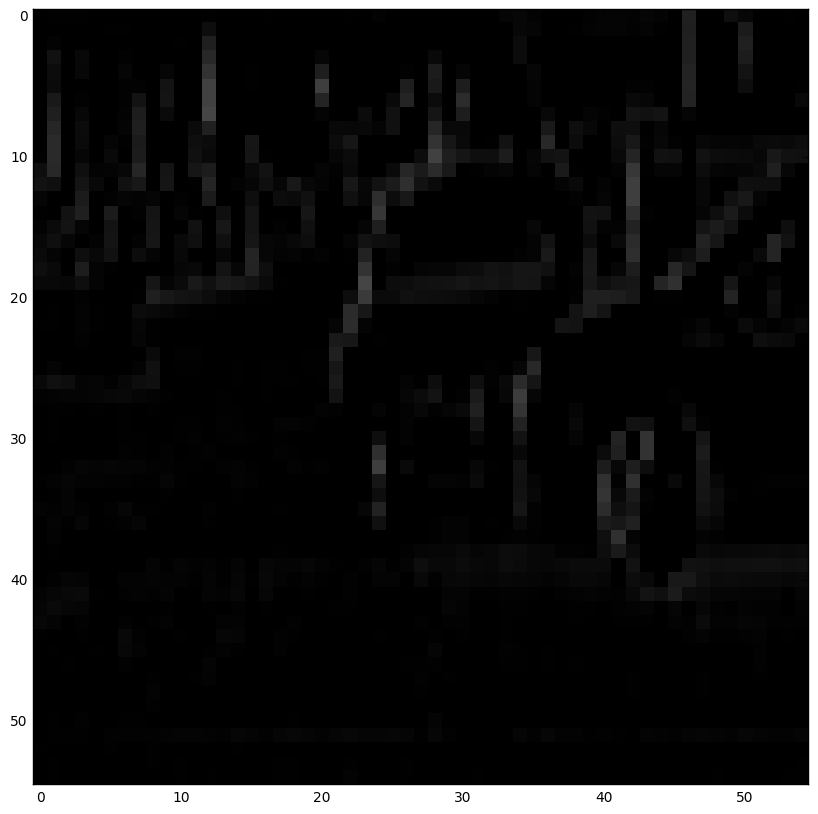

In [88]:
filt_min, filt_max = net.blobs['conv1-stack'].data.min(), net.blobs['conv1-stack'].data.max()
plt.imshow(net.blobs['conv1-stack'].data[0, 95], vmin = filt_min, vmax = filt_max)